# Линейные модели в машинном обучении

<div style='font-weight: 700; font-size: 18px'>Описание проекта</div>

Фермер, владелец молочного хозяйства «Вольный луг», хочет купить бурёнок, чтобы расширить поголовье стада коров.


**Необходимо** выполнить план развития молочного хозяйства. 

Для этого нужно отобрать коров по двум критериям:

- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Решение**

Создать две модели:

1. Прогнозирование удоя коровы
2. Предсказание вкуса молока

**План работы:**
- [Загрузка данных](#step1)
- [Предобработка данных](#step2)
- [Исследовательский анализ данных](#step3)
- [Корреляционный анализ](#step4)
- [Обучение модели линейной регрессии](#step5)
- [Обучение модели логистической регрессии](#step6)
- [Итоговые выводы](#step7)

In [1]:
# установка библиотеки phik
!pip install phik -q

# работа с данными
import pandas as pd
import numpy as np

# построение графиков
import matplotlib.pyplot as plt
import seaborn as sns

# корреляция
import phik

# модели МО
from sklearn.linear_model import LinearRegression, LogisticRegression

# разделение данных
from sklearn.model_selection import train_test_split

# масштабирование данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# оценка качества модели
from sklearn.metrics import (
    
    r2_score, 
    mean_absolute_error, 
    mean_squared_error, 
    
    confusion_matrix, 
    accuracy_score, 
    recall_score, 
    precision_score
)

from scipy import stats as st

# задание стилей графиков
sns.set_style('whitegrid')
sns.despine()

<Figure size 432x288 with 0 Axes>

<a id='step1'></a>
## Загрузка данных

### Чтение файлов

Загрузим исходные данные.

In [2]:
main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal = ',')
dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal = ',')

### Таблица `main`

Содержит информацию о стаде фермера на текущий момент.

**Характеристики коровы:**

- `id` — уникальный идентификатор коровы.
- `Порода` — порода коровы.
- `порода папы_быка` — порода папы коровы.
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).


**Характеристики корма:**

- `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.


**Характеристика пастбища:**

- `Тип пастбища` — ландшафт лугов, на которых паслась корова.


**Характеристики молока:**

- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
- `Жирность,%` — содержание жиров в молоке (в процентах).
- `Белок,%` — содержание белков в молоке (в процентах).
- `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).


In [3]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Приведем названия столбцов к общему виду.

In [4]:
# функция преобразования строк
def conversion(columns):
    return [col.replace(', ', ',').replace(',', ', ').replace('_', ' ').lower() for col in columns]

In [5]:
main.columns = conversion(main.columns)

# сократим длинные названия
main = main.rename(columns={
    'эке (энергетическая кормовая единица)': 'эке',
    'спо (сахаро-протеиновое соотношение)': 'спо'
})

main.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы быка,"жирность, %","белок, %",вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


### Таблица `dad`

Хранит имя папы каждой коровы в стаде фермера:

- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.

In [6]:
dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Приведем названия столбцов к общему виду.

In [7]:
dad.columns = conversion(dad.columns)

dad.head()

,id,имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


### Таблица `buy`

Содержит информацию о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой:

- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [8]:
buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Приведем названия столбцов к общему виду.

In [9]:
buy.columns = conversion(buy.columns)

buy = buy.rename(columns={
    'текущая жирность, %': 'жирность, %',
    'текущий уровень белок, %': 'белок, %'
})

buy.head()

,порода,тип пастбища,порода папы быка,имя папы,"жирность, %","белок, %",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


### Вывод

Были загружены таблицы с информацией о коровах фермера и «ЭкоФермы». Предоставленные исходные данные соответствуют описанию задачи.

Замечено, что:

- в данных отсутствуют пропуски
- используются различные формы записи категориальных значений
- в категориальных столбцах присутствуют неявные дубликаты


<a id='step2'></a>
##  Предобработка данных

### Преобразование типов


Все категориальные и количественные столбцы имеют корректный тип данных, преобразование не требуется.


### Пропуски

Подтвердим отсутствие пропусков.

In [10]:
if main.isna().sum().sum() == dad.isna().sum().sum() == buy.isna().sum().sum() == 0:
    print('В данных отсутствуют пропуски') 

В данных отсутствуют пропуски


### Дубликаты

#### Явные дубликаты

Проверим данные на наличие явных дубликатов.

***Таблица `main`***

В таблице `main` только поле `id` является уникальным, следовательно можно только его проверить на наличие явных дубликатов.

In [11]:
main.duplicated('id').sum()

5

Разным коровам не может быть присвоен одинаковый `id` - такие строки необходимо удалить.

In [12]:
# удаление дубликатов
main = main.drop_duplicates('id').reset_index(drop=True)

# проверка
main.duplicated('id').sum()

0

In [13]:
# количество строк в таблице после удаления дубликатов
main.shape[0]

629

***Таблица `dad`***

Для таблицы `dad` поступим аналогично.

In [14]:
dad.duplicated('id').sum()

0

В таблице отсутствуют явные дубликаты.

***Таблица `buy`***

In [15]:
buy.duplicated().sum()

4

В таблице `buy` есть полные дубликаты, однако каждой корове не присвоен идентификатор. Будем считать, что это разные, хоть и очень похожие, коровы.

#### Неявные дубликаты

Проверим категориальные столбцы на наличие неявных дубликатов.

***Таблица `main`***

Категориальные столбцы:

- `порода` — порода коровы.
- `тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы быка` — порода папы коровы.
- `вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- `возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Посмотрим, какие уникальные значения есть в этих столбцах.

In [16]:
categories = ['порода', 'тип пастбища', 'порода папы быка', 'возраст', 'вкус молока']

for cat in categories:
    print(f'{cat}: {main[cat].unique()}')

порода: ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища: ['Равнинное' 'Равнинные' 'Холмистое']
порода папы быка: ['Айдиал' 'Соверин' 'Айдиалл']
возраст: ['более_2_лет' 'менее_2_лет']
вкус молока: ['вкусно' 'не вкусно']


В столбцах `тип пастбища` и `порода папы быка` есть неявные дубликаты, уберем их, а также приведем все столбцы к одному виду:
- написание строчными буквами
- пробелы между словами

In [17]:
# преобразование категориальных столбцов
def cat_conversion(df, categories):
    
    for cat in categories:
        # приведение к общему виду
        df[cat] = conversion(df[cat])
        # проверка
        print(f'{cat}: {df[cat].unique()}')
    
    return df

In [18]:
# разделение слов
main.loc[main['порода'] == 'РефлешнСоверинг', 'порода'] = 'Рефлешн Соверинг'

# замена дубликатов
main.loc[main['тип пастбища'] == 'Равнинные', 'тип пастбища'] = 'Равнинное'
main.loc[main['порода папы быка'] == 'Айдиалл', 'порода папы быка'] = 'Айдиал'

# приведение к общему виду
main = cat_conversion(main, categories)

порода: ['вис бик айдиал' 'рефлешн соверинг']
тип пастбища: ['равнинное' 'холмистое']
порода папы быка: ['айдиал' 'соверин']
возраст: ['более 2 лет' 'менее 2 лет']
вкус молока: ['вкусно' 'не вкусно']


Можно предположить, что название породы коровы образуется путем объединения пород родителей. Если это так, признак `порода папы быка` не содержит новой информации. Проверим это.

In [19]:
breed ={'айдиал':'айдиал', 'соверин':'соверинг'}

for b in breed:
    # всего коров, у которых порода папы равна b 
    print(f'Всего {b} - {main.loc[(main["порода папы быка"] == b), "порода"].count()}')
    # проверка вхождения породы папы в породу коровы
    print(f'Совпадает - {main.loc[(main["порода папы быка"] == b), "порода"].apply(lambda x: True if breed[b] in x else False).sum()}')
    

Всего айдиал - 318
Совпадает - 200
Всего соверин - 311
Совпадает - 138


Более чем у половины коров такой закономерности не выявлено.

***Таблица `dad`***

Здесь только один категориальный столбец - `имя папы`. Немного обидно, что имя папы мы знаем, а ее — нет, но как говорится, как назовешь быка, столько его дочь и будет давать молока. Проверим, есть ли в этом столбце дубликаты.

In [20]:
dad['имя папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Достаточно скромный выбор имен, зато здесь нет неявных дубликатов. Приведем их тоже к общему виду.

In [21]:
# приведение к общему виду
dad = cat_conversion(dad, ['имя папы'])

имя папы: ['буйный' 'соловчик' 'барин' 'геркулес']


***Таблица `buy`***

Категориальные столбцы:

- `порода` — порода коровы.
- `тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы быка` — порода папы коровы.
- `имя папы` — имя папы коровы.
- `возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Посмотрим, какие уникальные значения есть в этих столбцах.

In [22]:
categories.pop()
categories.append('имя папы')

for cat in categories:
    print(f'{cat}: {buy[cat].unique()}')

порода: ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища: ['холмистое' 'равнинное']
порода папы быка: ['Айдиал' 'Соверин']
возраст: ['более_2_лет' 'менее_2_лет']
имя папы: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']


Аналогично проведем замену.

In [23]:
# разделение слов
buy.loc[buy['порода'] == 'РефлешнСоверинг', 'порода'] = 'Рефлешн Соверинг'

# приведение к общему виду
buy = cat_conversion(buy, categories)

порода: ['вис бик айдиал' 'рефлешн соверинг']
тип пастбища: ['холмистое' 'равнинное']
порода папы быка: ['айдиал' 'соверин']
возраст: ['более 2 лет' 'менее 2 лет']
имя папы: ['геркулес' 'буйный' 'барин' 'соловчик']


### Объединение данных

Для дальнейшей комфортной работы с данными объединим таблицы `main` и `dad`.

In [24]:
# проверим, что уникальные значения совпадают в обеих таблицах
if set(main['id'].values) == set(dad['id'].values):
    
    print('У каждой коровы есть папа\n')
    
    # объединение данных
    main = main.merge(dad, on='id')

# проверка
main.info()

У каждой коровы есть папа

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   удой, кг          629 non-null    int64  
 2   эке               629 non-null    float64
 3   сырой протеин, г  629 non-null    int64  
 4   спо               629 non-null    float64
 5   порода            629 non-null    object 
 6   тип пастбища      629 non-null    object 
 7   порода папы быка  629 non-null    object 
 8   жирность, %       629 non-null    float64
 9   белок, %          629 non-null    float64
 10  вкус молока       629 non-null    object 
 11  возраст           629 non-null    object 
 12  имя папы          629 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.8+ KB


Список уникальных значений совпадает, данные усешно объединены, все значения сохранены.

### Вывод

Была выполнена предобработка данных:

- приведены типы к `float` в столбцах `эке (энергетическая кормовая единица)`, `спо (сахаро-протеиновое соотношение)`, `жирность, %`, `белок, %`, `текущая жирность, %`, `текущий уровень белок, %`
- устранены явные дубликаты в таблице `main`
- приведены к общему виду и устранены неявные дубликаты в категориальных столбцах
- объединены таблицы `main` и `dad`

Примечание: 

В категориальных переменных нет единого формата записи строк. Так как категориальные столбцы имеют ограниченный набор слов, желательно ограничить ручной ввод. Это уменьшит влияние человеческого фактора на наличие ошибок в данных, а также ускорит и упростит работу с ними.

<a id='step3'></a>
## Исследовательский анализ данных

На основе информации о коровах фермера изучим характер распределения признаков.

### Функции

Реализуем необходимые для анализа функции.

**Оформление графиков**

In [25]:
# подписи осей
def chart_labels(title: str, ax, xlabel='удой, кг', ylabel='количество коров', xtick=10, ytick=10):
    
    ax.set_title(f'\n{title}\n', fontsize=16)
    
    ax.set_xlabel(f'\n{xlabel}', fontsize=12)
    ax.set_ylabel(f'{ylabel}\n', fontsize=12)
    
    ax.tick_params(axis='x', labelsize=xtick)
    ax.tick_params(axis='y', labelsize=ytick)
    

# добавление подписей к столбцам диаграммы  
def annotate(ax, kind='1'):
    
    if kind == '1':
        for p in ax.patches:
            # добавление подписи
            ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='left', va='center', fontsize=10, xytext=(5, 0), textcoords='offset points')

    elif kind == '2':
        for p in ax.patches:
            # добавление подписи
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=8, xytext=(0, 10), textcoords='offset points')

**Анализ количественных признаков**

In [26]:
# создание гистограммы и диаграммы размаха
def hist_box_plot(data=main, title='Распределение значений', xlabel='удой, кг', ylabel='количество коров', kind='3'):
    
    # создание графика
    fig, (ax_box, ax_count) = plt.subplots(2, figsize=(14,8), sharex = True, 
                                           gridspec_kw = {'height_ratios': (.1, .9)})

    # диаграмма размаха
    sns.boxplot(x=data[xlabel], ax=ax_box,
                 color='#8F94FB')
    # распределение значениий
    sns.histplot(data=data[xlabel], ax=ax_count,
                 color='#7F7FD5', alpha=0.3, kde=True)
    
    # среднее
    ax_count.axvline(x=data[xlabel].mean(), color='#5B5BB7', linestyle='-', label='среднее значение')
    # медиана
    ax_count.axvline(x=data[xlabel].median(), color='#7F7FD5', linestyle='--', label='медиана')
    
    # стили
    ax_count.legend()
    chart_labels(title=title, 
                 xlabel='', ylabel='', ax=ax_box)
    chart_labels(title='', 
                 xlabel=xlabel, ylabel=ylabel, ax=ax_count)
    
    # добавление подписей
    if kind == '2':
        annotate(ax_count, kind='2')

    return fig
    
    
# удаление выбросов
def remove_outliers(category: str, data=main):
    
    # квартили
    q1 = data[category].quantile(0.25)
    q3 = data[category].quantile(0.75)
    
    # значения усов
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # доля выбросов
    outliers = data.loc[(data[category] < lower) | (data[category] > upper), category].count()
    part = outliers / data[category].count() * 100
    
    if part < 15:
        
        print(f'Доля выбросов - {part:.2f}% \nУдалено {outliers} выбросов')
        return data[(data[category] >= lower) & (data[category] <= upper)]
    
    else:
        
        print(f'Доля выбросов - {part:.2f}% \nВыбросы оставлены')
        return data
    
    
# анализ количественного признака
def numerical(data=main, category='удой, кг', title='Распределение значений', kind='2'):
    
    # удаление выбросов
    data = remove_outliers(category=category, data=data)
    
    # сводная статистика
    print(f'\nСводная статистика столбца {category}')
    display(data[category].describe())
    
    # построение графиков
    fig = hist_box_plot(data=data, title=title, xlabel=category, kind=kind)
    
    return fig, data

**Анализ категориальных признаков**

In [27]:
# создание сводной таблицы с подсчетом количества значениий и их доли для каждой категории
def category_stats(category: str, data=main, val='id', func='count') -> pd.DataFrame:
    
    return (data
             # сводная таблица
             .pivot_table(index=category, values=val, aggfunc=func, margins=True, margins_name='Сумма')
             # добавлениие столбца с долей пользователей
             .assign(доля=lambda x: x.loc[x[val].index != 'Сумма', val] / x.loc['Сумма', val] * 100)
             # сортировка
             .sort_values(by='доля', ascending=False)
             # стили
             .style
             .format({'доля': '{:.2f}%'}, na_rep='100.00%')
             .highlight_max(color='yellowgreen', subset='доля')
             .highlight_min(color='coral', subset='доля')
             .highlight_max(color='lightblue', subset=val)
            )


# график распределения
def countplot(data=main, category='порода', size=(14, 6)):

    # создание графика
    fig, ax = plt.subplots(figsize=size)

    # cоздание палитры
    palette = sns.light_palette('#4E54C8', n_colors=6, reverse=True)
    brighter_color = sns.dark_palette('#4E54C8', n_colors=8, reverse=True)[2]

    palette[0:] = palette[1:]
    palette[0] = brighter_color

    # распределение значениий всех коров
    sns.countplot(y=category, data=data, order=data[category].value_counts().index, 
                  palette=palette, alpha=0.9, ax=ax)

    # стили
    chart_labels(title='Частота встречаемости', 
                 xlabel='количество коров', ylabel=category, ytick=12, ax=ax)
    annotate(ax)
    
    return fig


# анализ категориального признака
def categorical(data=main, category='порода', size=(14, 6)):
    
    display(category_stats(category=category, data=data, val='id', func='count'))
    fig = countplot(data=data, category=category, size=size)
    
    return fig

### Количественные признаки

Для начала посмотрим распределения количественных признаков.

In [28]:
# сводная статистика таблицы main
main.describe()

,id,"удой, кг",эке,"сырой протеин, г",спо,"жирность, %","белок, %"
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


В некоторых столбцах можно заметить аномальные значения. Так как нет возможности понять природу выбросов, и они могут негативно сказаться на предсазании модели, будем считать выбросами и удалять значения, не входящие в длину "усов" диаграммы размаха, доля которых составляет менее 15%.

Для контроля объема выборки зафиксируем текущее количество строк.

In [29]:
current = main['id'].count()
print(f'Текущее количество строк - {current}')

Текущее количество строк - 629


#### `Удой, кг` - целевой признак

Удалим выбросы, и по обновленным данным посмотрим сводную статистику данного столбца и построим гистограмму и диаграмму размаха.

Доля выбросов - 0.16% 
Удалено 1 выбросов

Сводная статистика столбца удой, кг


count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой, кг, dtype: float64

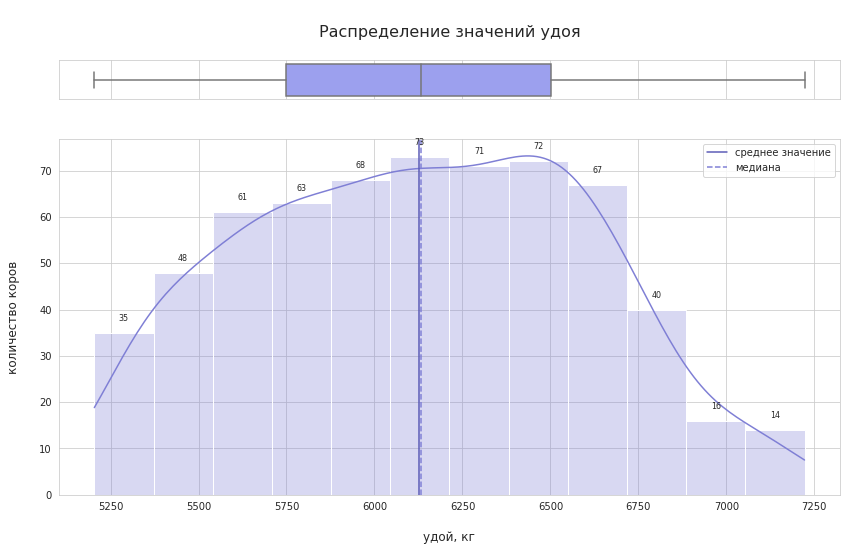

In [30]:
# анализ значений удоя
fig, main = numerical(data=main, category='удой, кг', title='Распределение значений удоя', kind='2')

Данное распределение ближе к **равномерному**, **среднее и медиана практически равны** и немного превышают 6100 кг, следовательно более половины коров соответствуют требованиям фермера по необходимому количеству молока. Преимущественно коровы имеют удой в диапазоне **5749.75 - 6501.00 кг**. Также был удален один выброс.

#### `Эке (энергетическая кормовая единица)`

Аналогично проведем анализ данного признака.

Доля выбросов - 0.00% 
Удалено 0 выбросов

Сводная статистика столбца эке


count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64

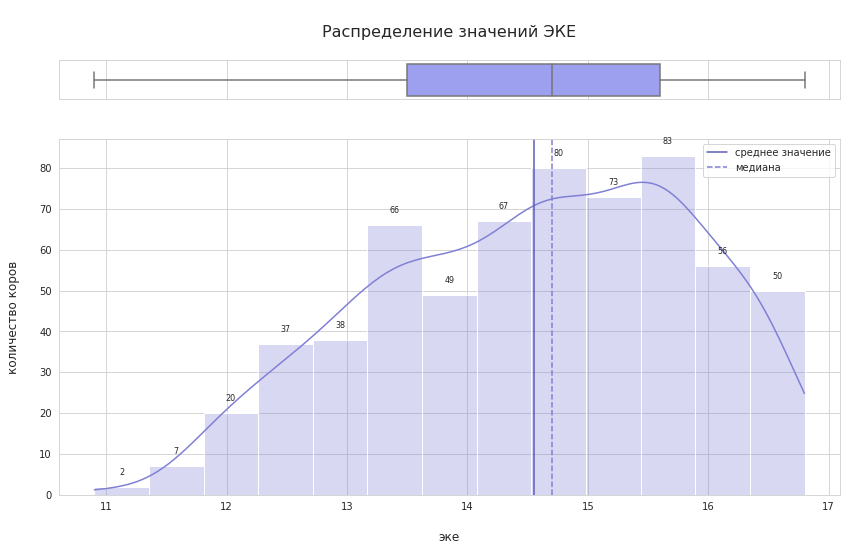

In [31]:
# анализ значений эке
fig, main = numerical(data=main, category='эке', title='Распределение значений ЭКЕ')

Данное распределение ближе к нормальному, скошенному влево, однако **медиана больше среднего**, а выбросов не выявлено, что может говорить о неравномерности распределения. Ограниченный **диапазон** значений **от 10.9 до 16.8** может говорить допустимых границах питательности корма. В основном значение ЭКЕ не ниже 14.7.

#### `Сырой протеин, г`


Доля выбросов - 0.00% 
Удалено 0 выбросов

Сводная статистика столбца сырой протеин, г


count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: сырой протеин, г, dtype: float64

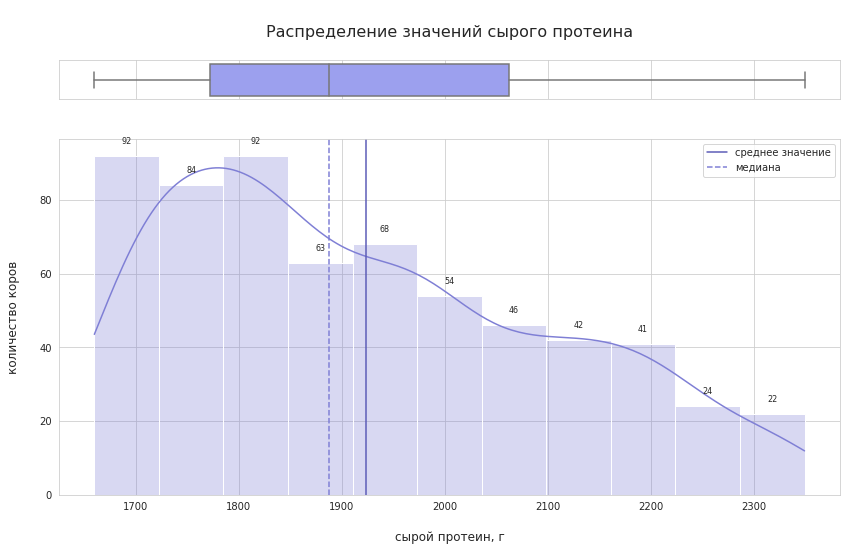

In [32]:
# анализ значений протеина
fig, main = numerical(data=main, category='сырой протеин, г', title='Распределение значений сырого протеина')

На данном графике видна обратная ситуация, где распределение скошено вправо, а **медиана меньше среднего**, выбросов также не обнаружено. Сырой протеин принимает значения **от 1660 до 2349 г**. **В 50%** случаев значение протеина **не выше 1888 г**.

#### `Спо (сахаро-протеиновое соотношение)`


Доля выбросов - 0.00% 
Удалено 0 выбросов

Сводная статистика столбца спо


count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64

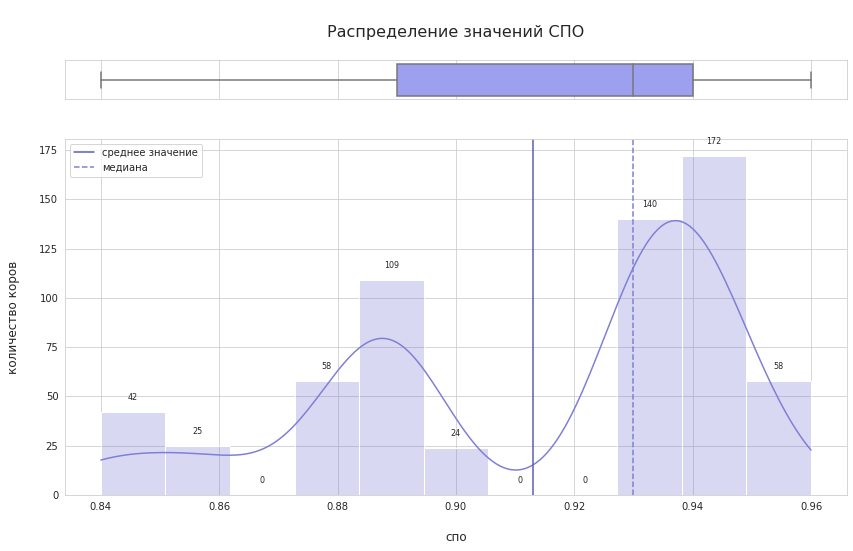

In [33]:
# анализ значений спо
fig, main = numerical(data=main, category='спо', title='Распределение значений СПО')

На графике видно **мультимодельное распределение**, в котором присутствует три изолированных несимметричных пика значений, из-за чего **среднее и медиана** достаточно **далеки** друг от друга и не отражают характер распределениия. Возможно, на значение СПО влияют другие признаки. Выбросов не обнаружено.

#### `Жирность, %`


Доля выбросов - 13.69% 
Удалено 86 выбросов

Сводная статистика столбца жирность, %


count    542.000000
mean       3.663173
std        0.076373
min        3.400000
25%        3.620000
50%        3.710000
75%        3.720000
max        3.750000
Name: жирность, %, dtype: float64

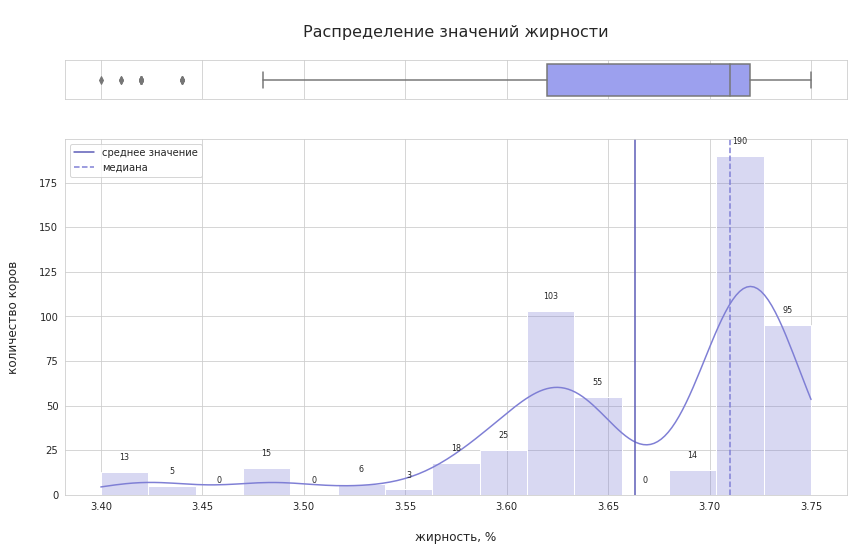

In [34]:
# анализ значений жирности
fig, main = numerical(data=main, category='жирность, %', title='Распределение значений жирности')

Данное распределение также **мультимодальное** с двумя выраженными пиками значений, однако присутствуют значения, которые не относятся к ним. **Среднее и медиана** также **не совпадают**. Хотя в данном столбце было обнаружено и удалено большое количество выбросов, из-за неравномерного распределения появились новые выбросы.

#### `Белок, %`


Доля выбросов - 0.74% 
Удалено 4 выбросов

Сводная статистика столбца белок, %


count    538.000000
mean       3.075623
std        0.002481
min        3.070000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.081000
Name: белок, %, dtype: float64

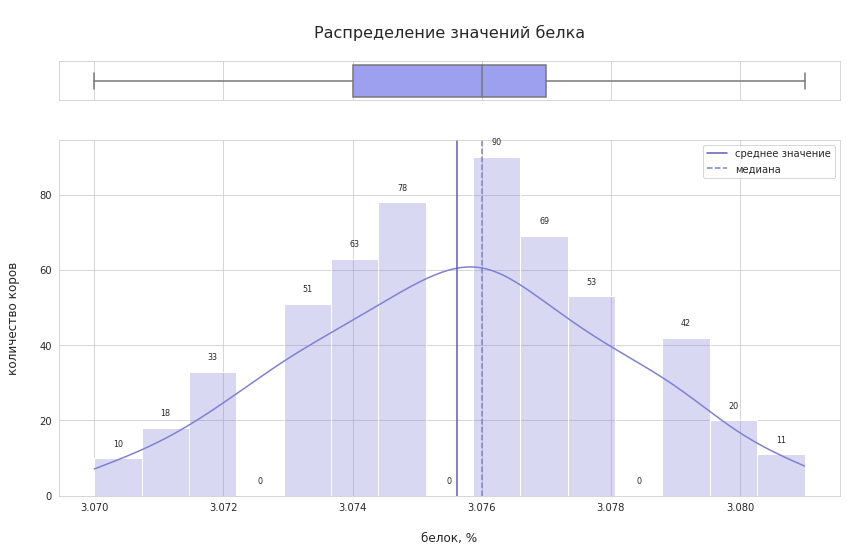

In [35]:
# анализ значений белка
fig, main = numerical(data=main, category='белок, %', title='Распределение значений белка')

Данное распределение достаточно широкое, но симметричное и ближе к нормальному, однако из-за наличия пустых интервалов медиана смещена относительно среднего значения. Также было удалено 4 выброса.

#### Проверка объема данных

Посмотрим, насколько сократился размер данных.

In [36]:
current2 = main['id'].count()
print(f'Было {current} строк \nСтало {current2} строк \nДоля удаленных строк - {(current-current2)/current*100:.2f}%')

Было 629 строк 
Стало 538 строк 
Доля удаленных строк - 14.47%


Было **удалено менее 15%** от изначального объема данных, что является приемлемым.

### Категориальные признаки

Ознакомимся с распределением категориальных признаков.

#### `Вкус молока` - целевой признак

Построим сводную таблицу, в которой отобразим колчество коров, которые дают вкусное и невкусное молоко, а таже их долю от общего количества.

,id,доля
вкус молока,,
вкусно,322,59.85%
не вкусно,216,40.15%
Сумма,538,100.00%


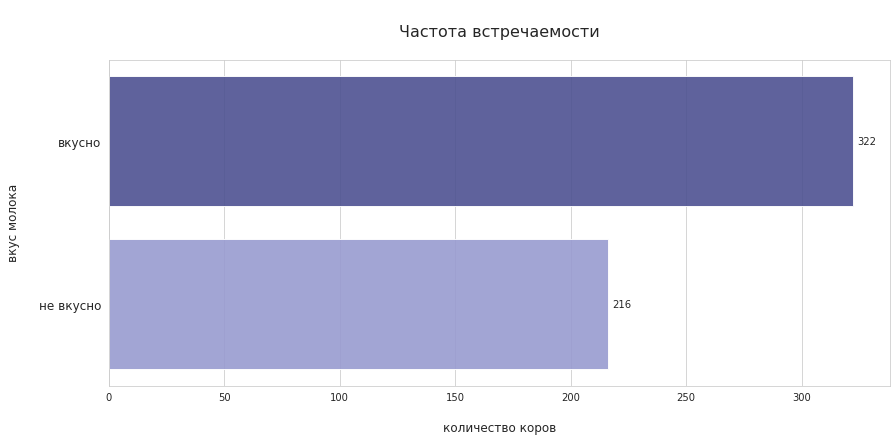

In [37]:
fig = categorical(data=main, category='вкус молока')

**Более 40%** от общего количества коров дают **невкусное молоко**.

#### `Порода`

Аналогично построим сводную таблицу и график распределения.


,id,доля
порода,,
вис бик айдиал,318,59.11%
рефлешн соверинг,220,40.89%
Сумма,538,100.00%


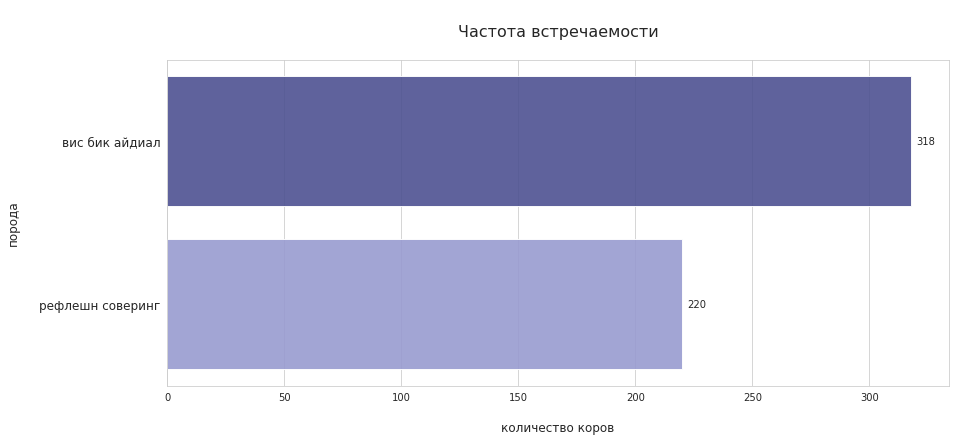

In [38]:
fig = categorical(data=main, category='порода')

У фермера чаще встречаются коровы породы **Вис Бик Айдиал - их 59%**.

#### `Тип пастбища`

Аналогично изучим столбец `тип пастбища`.


,id,доля
тип пастбища,,
холмистое,299,55.58%
равнинное,239,44.42%
Сумма,538,100.00%


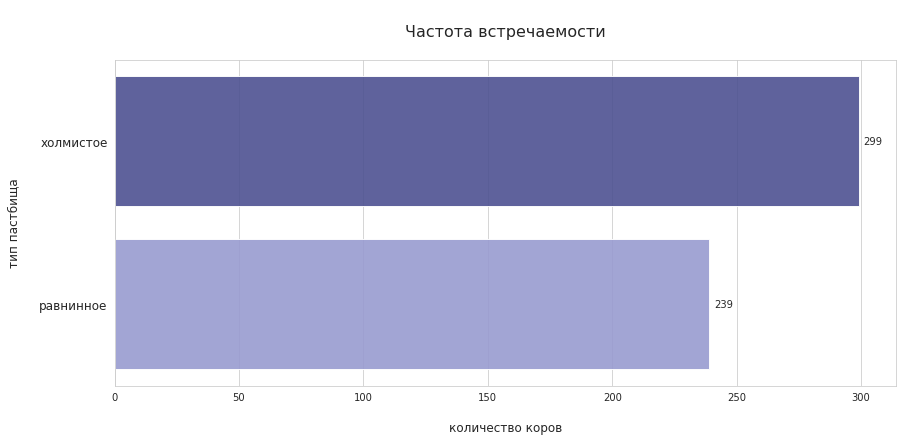

In [39]:
fig = categorical(data=main, category='тип пастбища')

Немного **чаще** коровы **пасутся на холмистом пастбище**.

#### `Порода папы быка`

,id,доля
порода папы быка,,
айдиал,277,51.49%
соверин,261,48.51%
Сумма,538,100.00%


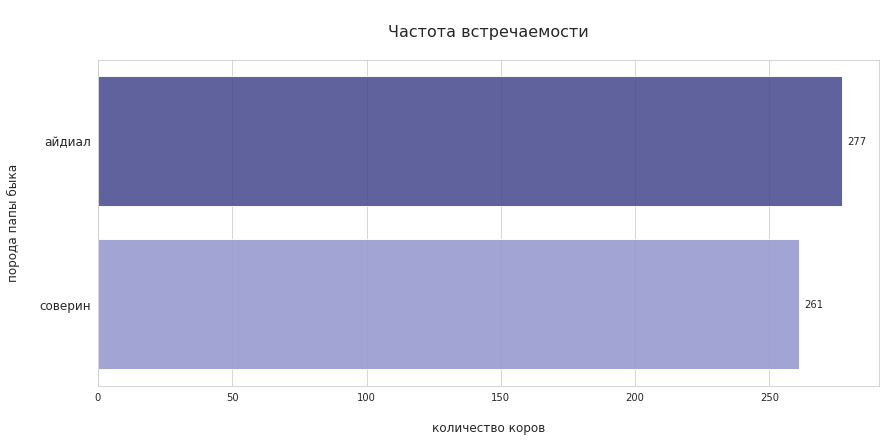

In [40]:
fig = categorical(data=main, category='порода папы быка')

Примерно равное количество пап коров с разными породами.

#### `Возраст`

,id,доля
возраст,,
более 2 лет,481,89.41%
менее 2 лет,57,10.59%
Сумма,538,100.00%


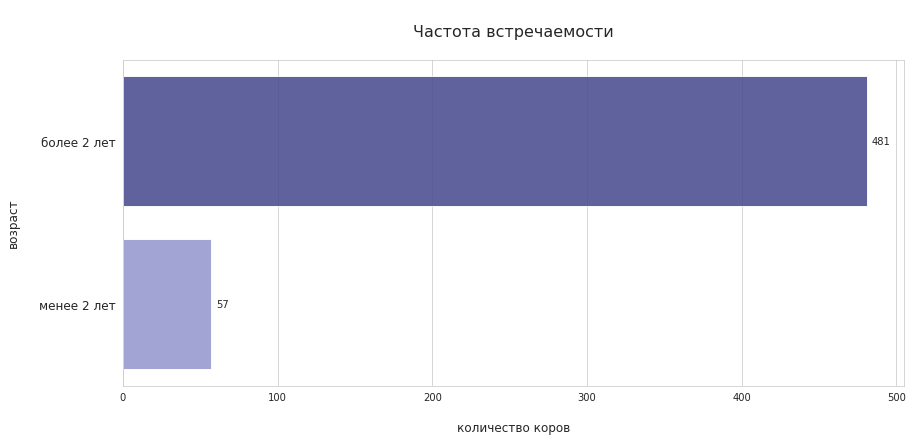

In [41]:
fig = categorical(data=main, category='возраст')

Преимущественно (**более 80%**) в стаде фермера **коровам более двух лет**.

#### `Имя папы`

,id,доля
имя папы,,
барин,197,36.62%
буйный,188,34.94%
соловчик,96,17.84%
геркулес,57,10.59%
Сумма,538,100.00%


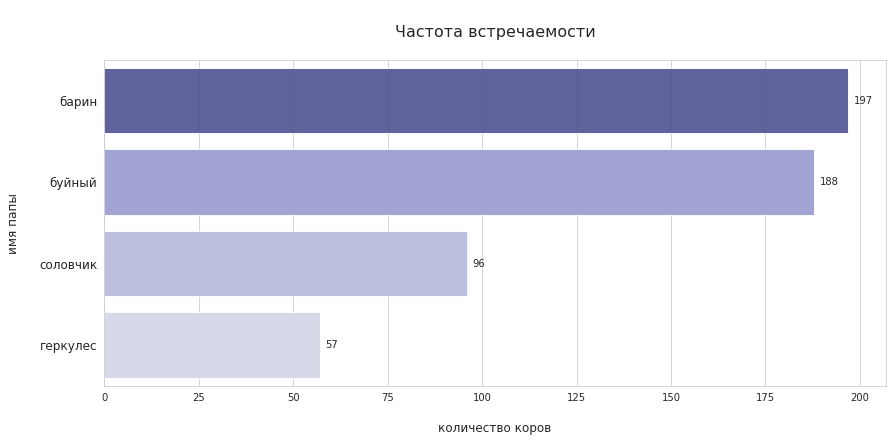

In [42]:
fig = categorical(data=main, category='имя папы')

Самы **популярные имена - Барин и Буйный**, непопулярное - Геркулес.

### Вывод

Были проанализированы распределения значений признаков, построены диаграммы и удалены выбросы.

- удой соответствует требованиям, однако более **40% коров дают невкусное молоко**
- большинство коров (**59%**) принадлежат породе **Вис Бик Айдиал**
- корм питательный (**медиана ЭКЕ = 14.7**)
- коровы чаще **пасутся на холмистом пастбище**
- **популярные** имена пап - **Барин и Буйный**
- **большинство** коров **старше двух лет**
- распределения протеина, жирности, и спо имеют свои особенности

<a id='step4'></a>
## Корреляционный анализ

### Матрицы корреляции

Для оценки корреляции между количественными признаками построим матрицу корреляции Пирсона. Так как в столбцах `спо` и `жирность, %` распределение мультимодально, не будем использовать коэффициент корреляции Пирсона для данных признаков.

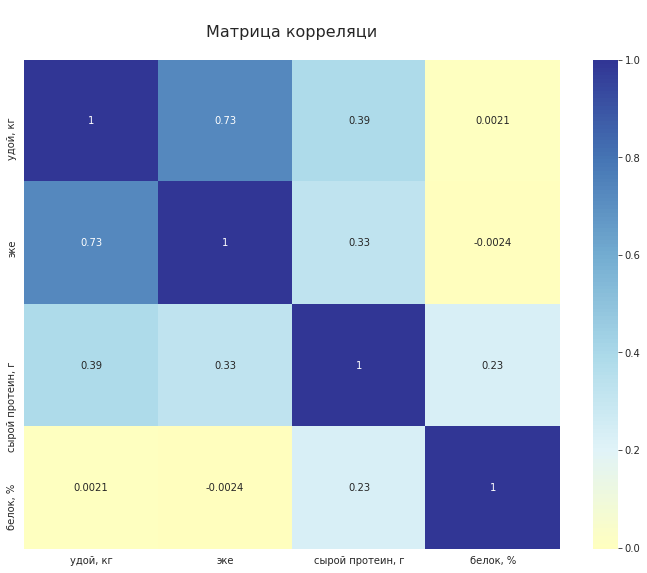

In [43]:
# функция построения матрицы корреляции
def corr(data):
    fig, ax = plt.subplots(figsize=(12, 9))
    
    sns.heatmap(data, annot=True, center=0, cmap= 'RdYlBu')
    
    chart_labels(title='Матрица корреляци', 
                 xlabel='', ylabel='', ax=ax)
    
    plt.show()
    
# матрица корреляции количественных признаков
corr(main[['удой, кг', 'эке', 'сырой протеин, г', 'белок, %']].corr())

Между всеми признаками, кроме белка, положительная корреляция. **`Уровень белка`** в молоке является **наименее коррелирующим** признаком. `Сырой протеин` также имеет невысокую связь. 

Целевой признак **`удой`** наиболее **хорошо коррелрует** с `эке`. Мультиколлинеарности не наблюдается.


Так как данные содержат как категориальные, так и количественные признаки,  для оценки связи и отбора признаков используем корреляцию Фи-Квадрат.

interval columns not set, guessing: ['удой, кг', 'эке', 'сырой протеин, г', 'спо', 'жирность, %', 'белок, %']


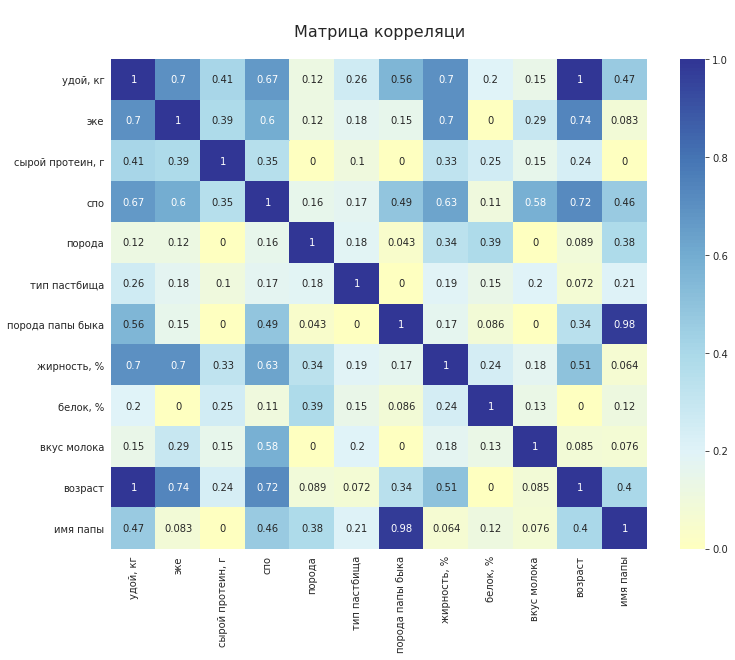

In [44]:
# матрица корреляции для всех признаков
corr(main.loc[:, 'удой, кг':].phik_matrix())

Сильнее всего целевой признак `удой, кг` коррелирует с `возрастом`, `спо` и `жирностью`, коэффициент корреляции равен 1, слабее всего - с `породой` (0.12).

У целевого признака `вкус молока` хорошая связь только с `спо` - 0.58, для признаков `порода` и `порода папы быка` коэффициент корреляции равен нулю.

Так как у целевого признака `удой, кг` хорошая корреляция со многими количественными признаками, из данной матрицы можно взять категориальные признаки с порогом 0.2: `тип пастбища`, `порода папы быка`, `возраст`, `спо` и `жирность, %`.

Целевой признак `вкус молока` хорошо коррелирует только с `спо`, поэтому снизим порог до 0.1: `эке`, `сырой протеин, г`, `спо`, `тип пастбища`, `жирность, %`, `белок, %`.

Можно заметить, что показатель жирности молока зависит от характеристик корма, в отличие от белка.

Замечена мультиколлинерарность между признаками `имя папы` и `порода папы быка`.

### Диаграммы рассеяния

Для лучшего понимания характера связи целевого признака `удой, кг` с остальными построим диаграммы рассеяния для каждого признака с учетом категориальных. Также покажем границу в 6000 кг для удоя, чтобы лучше оценить зависимость с категориальными признаками. 

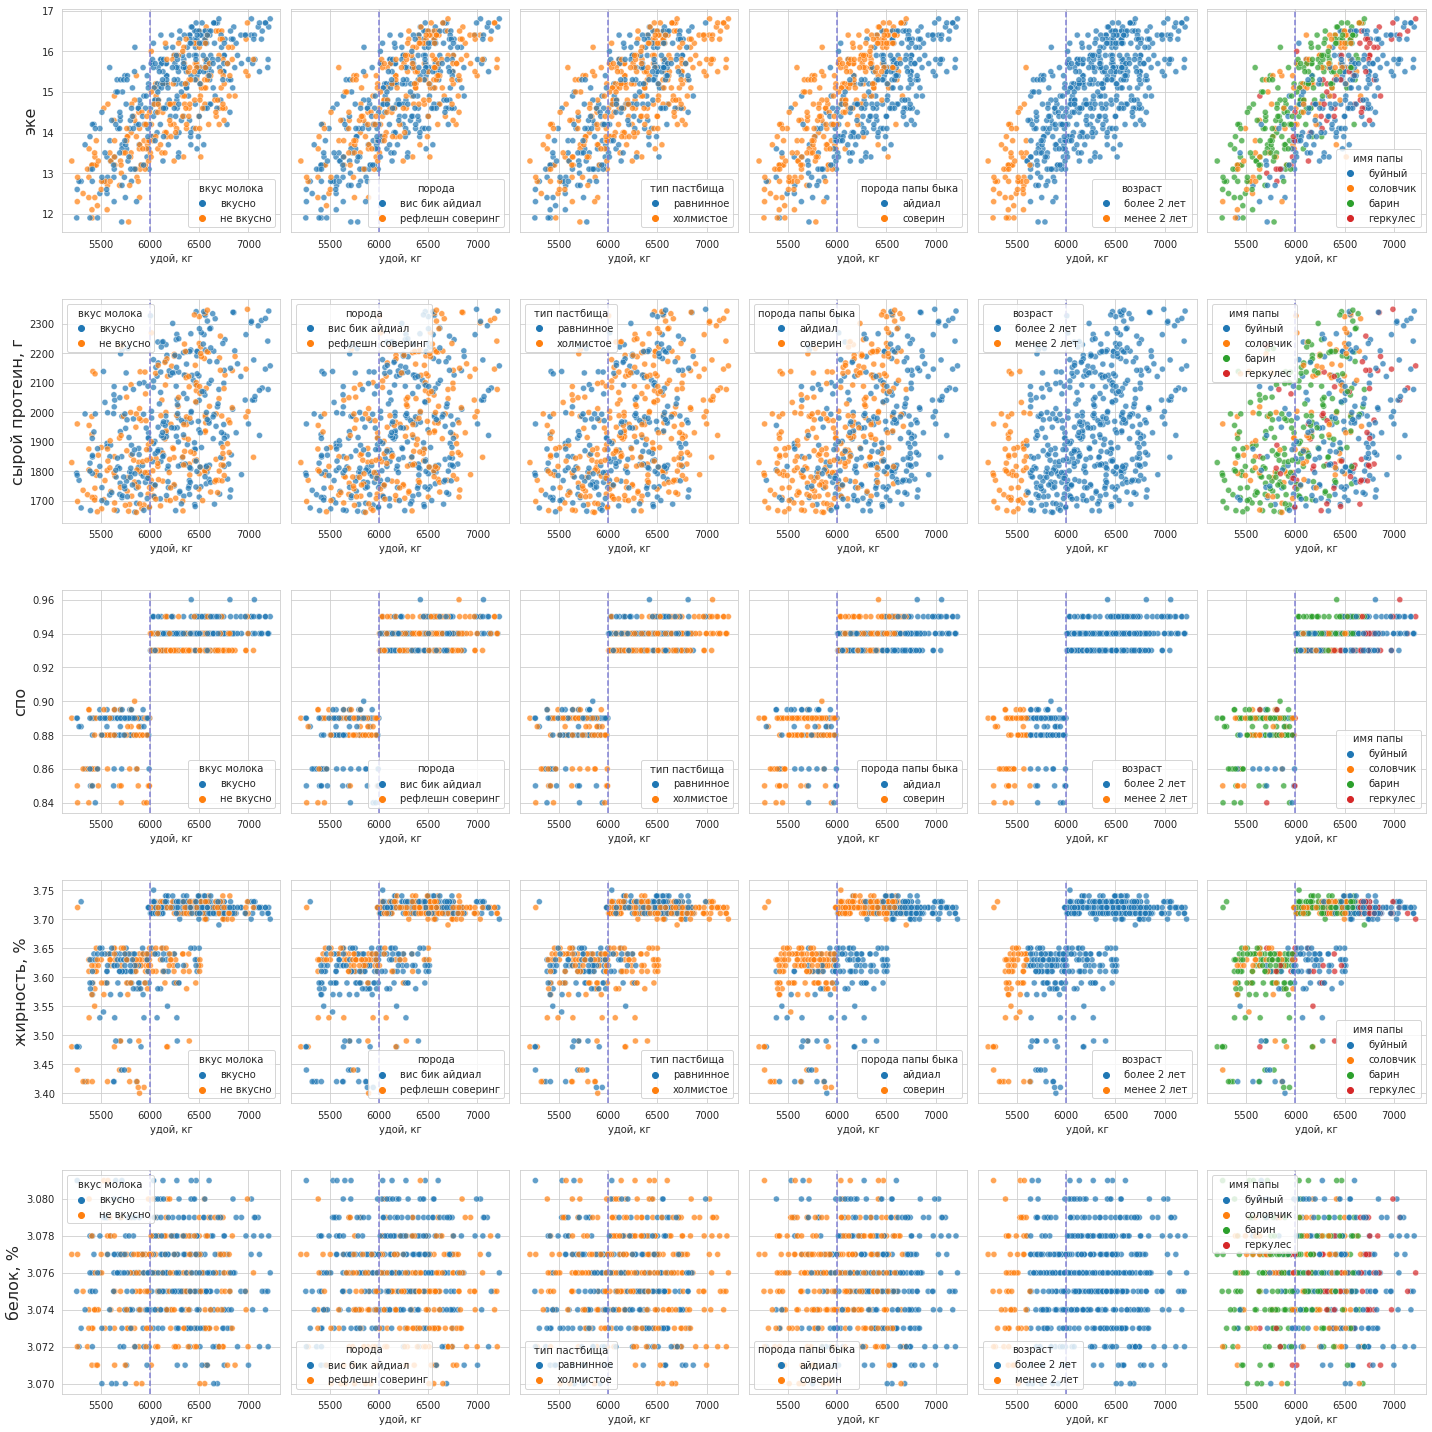

In [45]:
# список количественных и категориальных столбцов
num = ['эке', 'сырой протеин, г', 'спо', 'жирность, %', 'белок, %']
cat = ['вкус молока', 'порода', 'тип пастбища', 'порода папы быка', 'возраст', 'имя папы']

fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(20, 20))

for row in  range(len(num)):
    for col in range(len(cat)):
        
        # порог
        ax[row, col].axvline(x=6000, color='#7F7FD5', linestyle='--')
        
        # построение scatterplot для каждого признака
        sns.scatterplot(x='удой, кг', y=num[row], hue=cat[col], data=main, ax=ax[row, col], alpha=0.7)

        if col == 0:
            # добавление оси y
            ax[row, col].set_ylabel(num[row], fontsize=16)
            
        else:
            # удаление оси y
            ax[row, col].set_ylabel(None)
            ax[row, col].set_yticklabels([])

# параметры графиков
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.show()

По графикам хорошо видно, что **у коров до двух лет удой менее 6000 кг**, а все остальные показатели ниже. Чтобы понять, покупать ли молодых коров, необходимо проанализировать, как меняются эти показатели с возрастом.

Так как признаки `спо` и `жирность, %` имеют четкую границу, стоит **преобразовать их в категориальные**: `спо` по границе 0.91, а `жирность, %` - 3.675. Можно заметить, что, если `спо` или `жирность` меньше порога, а `порода папы быка` Соверин, удой менее 6000 кг. 

При анализе признака `эке` обнаружена зависимость, которая представляет собой смесь линейной и квадратичной зависимостей. Если предположить, что она все-таки квадратичная, можно попробовать это устранить возведением в квадрат.

У признака `белок, %` линейная связь очень слабая, однако можно его учесть.

Значение `спо` у невкусного молока в основном **менее 0.89** или равняется **0.93**.

### Вывод

Был проведен корреляционный анализ количественных и категориальных признаков, в результате которого выявлены следующие закономерности:

**`удой, кг`**
- **хорошо коррелрует** с **`эке`**, **`спо`** и **`жирностью`**
- коэффициент корреляции с признаком **`возраст`** равен **1**

**`вкус молока`**
- хорошая связь только с **`спо` - 0.58**
- для признаков `порода` и `порода папы быка` **коэффициент корреляции равен нулю**.

**остальные закономерности**
- **`белок, %`** имеет **слабую связь** со всеми количественными признаками
- **мультиколлинерарность** наблюдается только между признаками **`имя папы`** и **`порода папы быка`**, однако можно проверить, как этот признак будет влиять на модель
- значения признаков **`спо` и `жирность, %`** сгруппированы - их можно **преобразовать в категориальные**


**Отобранные признаки**

**Целевой признак `удой, кг`**:  `эке`, `сырой протеин, г` ,`спо`, `жирность, %`, `белок, %`, `тип пастбища`, `порода папы быка`, `возраст`.

**Целевой признак `вкус молока`**: `эке`, `сырой протеин, г`, `спо`, `тип пастбища`, `жирность, %`, `белок, %`.


<a id='step5'></a>
## Обучение модели линейной регрессии

Для нахождения лучшей модели линейной регрессии создадим три модели:

1. Отобранные ранее признаки
2. Преобразование признаков `спо` и `жирность, %` в категориальные, 
3. Добавление признака `имя папы`

### Функции

Создадим необходимые функции.

**Подготовка данных**

In [46]:
# StandardScaler
def standard(num_col_names, X_train, X_test):
    
    # создание экземпляра класса StandardScaler()
    scaler = StandardScaler()

    # обучение и трансформирование количественных признаков из тренировочной выборки 
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])

    # преобразование количественных признаков в тестовой выборке
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
    return scaler, X_train_scaled, X_test_scaled


# OneHotEncoder
def onehot(cat_col_names, X_train, X_test):
    
    # создание экземпляра класса OneHotEncoder()
    encoder = OneHotEncoder(drop='first', sparse=False)

    # обучение и трансформирование категориальных признаков из тренировочной выборки 
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

    # преобразование категориальных признаков в тестовой выборке
    X_test_ohe = encoder.transform(X_test[cat_col_names])

    # список новых столбцов
    encoder_col_names = encoder.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    return encoder, X_train_ohe, X_test_ohe
    

# масштабирование данных
def scaling(num_col_names, cat_col_names, X_train, X_test, srch):
    
    # результаты преобразования признаков
    scaler, X_train_scaled, X_test_scaled = standard(num_col_names, X_train, X_test)
    encoder, X_train_ohe, X_test_ohe = onehot(cat_col_names, X_train, X_test)

    # объединение преобразованных данных
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    if not(srch):
        # проверка
        display(X_train.head())
    
    return scaler, encoder, X_train, X_test
    
    
# подготовка данных    
def prepare_data(num_col_names, cat_col_names, target, RANDOM_STATE, srch):
    
    X = main[num_col_names+cat_col_names]
    y = main[target]

    # разделение на обучающую и тренировочную выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        random_state=RANDOM_STATE
    )
    
    # масштабирование
    scaler, encoder, X_train, X_test = scaling(num_col_names, cat_col_names, X_train, X_test, srch)
    
    return scaler, encoder, X_train, X_test, y_train, y_test


# построение графиков по количественным признакам
def graph(num_col_names, X_train):
    
    fig, ax = plt.subplots(2, figsize=(14, 8), sharex=True, 
                      gridspec_kw={'height_ratios': (.35, .6)})

    # диаграмма размаха
    sns.boxplot(data=X_train[num_col_names], ax=ax[0],
                palette='RdYlBu_r', orient='h')
    # гистограмма распределения
    sns.histplot(data=X_train[num_col_names], ax=ax[1],
                 palette='RdYlBu_r', alpha=0.6, kde=True)

    # настройка подписей к графикам
    chart_labels(title='Разброс значений признаков', 
                 xlabel='', ylabel='', ax=ax[0])
    chart_labels(title='Гистограмма распределения', 
                 xlabel='диапазон значений', ylabel='количество', ax=ax[1])
    
    plt.show()
    
    return fig

**Создание и анализ модели**

In [47]:
# создание и обучение модели
def fit_lr(X_train, y_train, X_test, y_test, srch):
    
    # инициализация модели
    model_lr  = LinearRegression()

    # обучение на тренировочных данных
    model_lr.fit(X_train, y_train)

    # предсказания модели на тестовых данных 
    predictions = model_lr.predict(X_test)
    
    if not(srch):
        # проверим точность предсказания на тренировочных данных, чтобы убедиться в отсутствии переобучения
        predictions_tr = model_lr.predict(X_train)
        r2_tr = r2_score(y_train, predictions_tr)
        print(f'R2 train = {r2_tr:.3f}')
    
        # посмотрим, какое влияние у каждого признака
        print('\n\033[1mВеса модели:\033[0m')
    
        for feature_number, feature_name in enumerate(X_train.columns):
            weight = model_lr.coef_[feature_number]
            print(f'{feature_name:<20}: {weight:+.6f}') 
    
    return model_lr, predictions
    

# анализ качества модели
def metrics(y_test, predictions):
    
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions)**0.5
    
    print('\n\033[1mКачество модели:\033[0m')
    print(f'R2 = {r2:.4f}')
    print(f"MAE = {mae:.2f}")
    print(f"MSE = {mse:.2f}")
    print(f"RMSE = {rmse:.2f}\n")
    

# анализ остатков
def analyze_residuals(y_test, predictions):
    
    # рассчет остатков
    residuals = y_test-predictions

    fig, ax = plt.subplots(1, 2, figsize=(16, 6), 
                      gridspec_kw={'width_ratios': (.6, .4)})

    # среднее
    ax[0].axvline(x=residuals.mean(), color='#5B5BB7', 
                  linestyle='--', label=f'{residuals.mean():.1f} - среднее')
    
    # гистограмма распределения
    sns.histplot(data=residuals, ax=ax[0], 
                 color='#7F7FD5', alpha=0.6, kde=True)
    # диаграмма рассеяния
    sns.scatterplot(x=predictions, y=residuals, ax=ax[1],
                color='#7F7FD5', alpha=0.7)

    # настройка подписей к графикам
    chart_labels(title='Гистограмма распределения остатков', 
                 xlabel='Остатки', ylabel='', ax=ax[0])
    chart_labels(title='Анализ дисперсии', 
                 xlabel='Предсказания модели', ylabel='Остатки', ax=ax[1])

    ax[0].legend()
    plt.show()
    
    return fig
    

**Объединим все в одну функцию**

In [48]:
# модель линейной регрессии
def LR(num_col_names, cat_col_names, target='удой, кг', RANDOM_STATE=42):
    
    # подготовка данных 
    (scaler, encoder, 
     X_train, X_test, y_train, y_test) = prepare_data(num_col_names, cat_col_names, target, RANDOM_STATE, srch=False)
    
    # гистограмма частотности распределения и ящик с усами отмасштабированных признаков
    fig = graph(num_col_names, X_train)
    
    # модель LR
    model_lr, predictions = fit_lr(X_train, y_train, X_test, y_test, srch=False)
    
    # метрики
    metrics(y_test, predictions)
    
    # анализ остатков
    fig_r = analyze_residuals(y_test, predictions)
    
    return model_lr, scaler, encoder, fig, fig_r
    

### Первая модель линейной регрессии

Создадим первую модель линейной регресси на основе ранее отобранных признаков: `эке`, `сырой протеин, г` ,`спо`, `жирность, %`, `белок, %`, `тип пастбища`, `порода папы быка`, `возраст`.

,x0_холмистое,x1_соверин,x2_менее 2 лет,эке,"сырой протеин, г",спо,"жирность, %","белок, %"
0,1.0,0.0,0.0,1.278302,2.206848,0.730876,0.615452,1.860253
1,1.0,1.0,0.0,0.774892,0.343083,0.730876,0.615452,0.208971
2,0.0,0.0,0.0,0.355385,-0.705285,0.399929,0.742126,-1.442311
3,0.0,1.0,0.0,-0.735336,0.293161,-0.923860,-0.524611,0.208971
4,0.0,0.0,0.0,0.355385,-0.666456,0.399929,0.868799,-0.616670


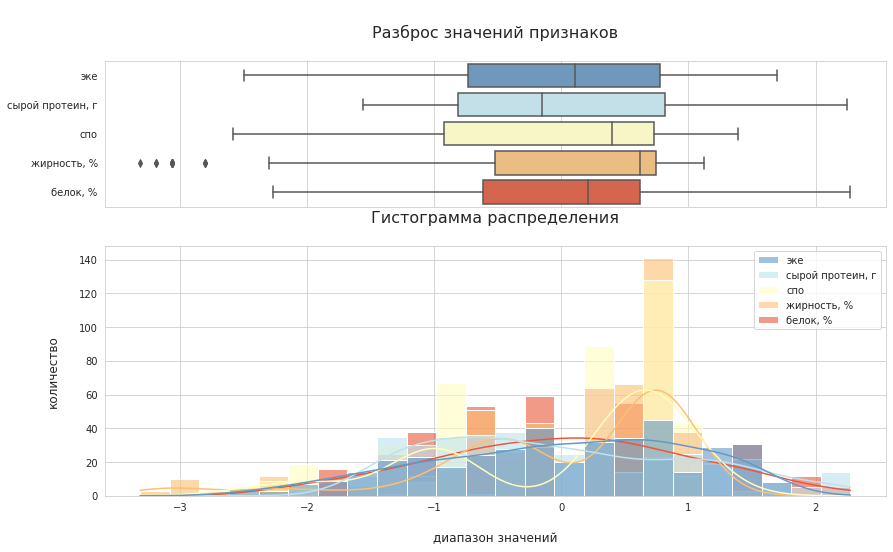

R2 train = 0.825

Веса модели:
x0_холмистое        : +73.020612
x1_соверин          : -289.223111
x2_менее 2 лет      : -193.280222
эке                 : +142.129740
сырой протеин, г    : +49.372392
спо                 : +110.459686
жирность, %         : +80.775832
белок, %            : -27.783465

Качество модели:
R2 = 0.7777
MAE = 151.75
MSE = 39057.13
RMSE = 197.63



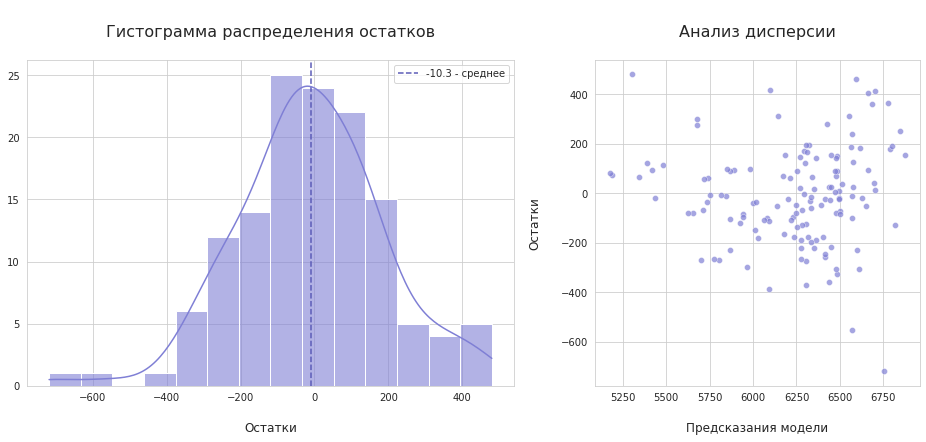

In [49]:
# спиисок категориальных и количественных признаков
cat_col_names = ['тип пастбища', 'порода папы быка', 'возраст']
num_col_names = ['эке', 'сырой протеин, г' ,'спо', 'жирность, %', 'белок, %']

# первая модель линейной регрессии
model_lr1, scaler1, encoder1, fig1, fig_r1 = LR(num_col_names, cat_col_names)

**Количественные признаки** были успешно **отмасштабированы** и **принимают значения** в дианазоне **от -4 до 3**. 

**Сильнее** всего на предсказание модели **влияют** признаки **`порода папы быка` и `возраст`**, а **слабее** всего - **`белок, %`**.

Получившаяся модель неплохо обучилась: **78% предсказаний** модели **ближе к истине**, чем среднее значение целевого признака. 
Значение MAE говорит о том, что **модель в среднем ошибается на 158 кг** при прогнозировании удоя коровы. 
Наличие выбросов сказывается на **RMSE** - оно выше, чем MAE, и **равно 198 кг**.

Гистограмма распределения остатков показывает **равномерное распределение с небольшим сдвигом влево и двумя выбросами**. Это говорит о том, что модель больше завышает предсказания.

Анализ дисперсии выявил увеличение разброса ошибки при предсказании удоя более 6000 кг.

### Вторая модель линейной регрессии

Преобразуем признаки `спо` и `жирность, %` в категориальные и возведем `эке` в квадрат.

In [50]:
# функция для разделения на категории
def to_cat(x, lim):
    return f'больше {lim}' if x > lim else f'меньше {lim}'

# преобразование в категориальные признаки
main['спо кат'] = main['спо'].apply(lambda x: to_cat(x, 0.915))
main['жирность кат'] = main['жирность, %'].apply(lambda x: to_cat(x, 3.675))

# возведение эке в квадрат
main['эке кв'] = main['эке']**2

# проверка
main.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы быка,"жирность, %","белок, %",вкус молока,возраст,имя папы,спо кат,жирность кат,эке кв
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более 2 лет,буйный,меньше 0.915,меньше 3.675,201.64
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее 2 лет,соловчик,меньше 0.915,меньше 3.675,163.84
2,3,5810,14.0,1854,0.885,рефлешн соверинг,холмистое,соверин,3.59,3.074,не вкусно,более 2 лет,барин,меньше 0.915,меньше 3.675,196.00
3,4,5895,12.4,2012,0.885,рефлешн соверинг,холмистое,айдиал,3.40,3.075,не вкусно,более 2 лет,буйный,меньше 0.915,меньше 3.675,153.76
4,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее 2 лет,барин,меньше 0.915,больше 3.675,163.84


,x0_холмистое,x1_соверин,x2_менее 2 лет,x3_меньше 0.915,x4_меньше 3.675,эке кв,"сырой протеин, г","белок, %"
0,1.0,0.0,0.0,0.0,0.0,1.321902,2.206848,1.860253
1,1.0,1.0,0.0,0.0,0.0,0.769271,0.343083,0.208971
2,0.0,0.0,0.0,0.0,0.0,0.324575,-0.705285,-1.442311
3,0.0,1.0,0.0,1.0,1.0,-0.764282,0.293161,0.208971
4,0.0,0.0,0.0,0.0,0.0,0.324575,-0.666456,-0.616670


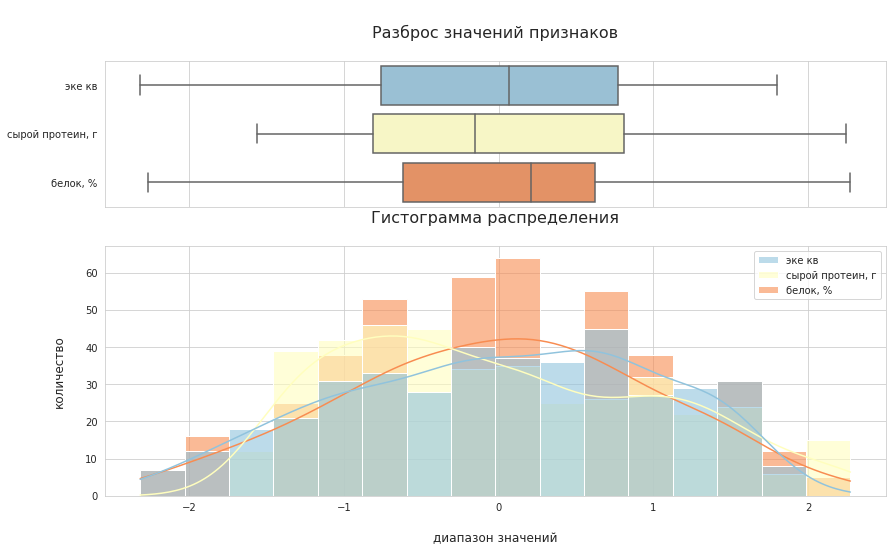

R2 train = 0.852

Веса модели:
x0_холмистое        : +59.420630
x1_соверин          : -271.389933
x2_менее 2 лет      : -239.780440
x3_меньше 0.915     : -204.851225
x4_меньше 3.675     : -238.909477
эке кв              : +124.748136
сырой протеин, г    : +39.286058
белок, %            : -19.427771

Качество модели:
R2 = 0.7870
MAE = 146.38
MSE = 37433.50
RMSE = 193.48



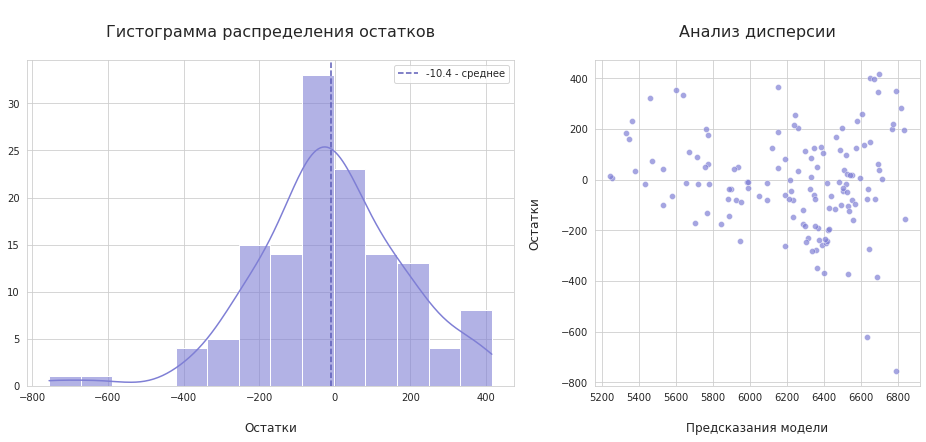

In [51]:
# зададим новый список категориальных и количественных признаков
cat_col_names = ['тип пастбища', 'порода папы быка', 'возраст', 'спо кат', 'жирность кат']
num_col_names = ['эке кв', 'сырой протеин, г', 'белок, %']

# вторая модель линейной регрессии
model_lr2, scaler2, encoder2, fig2, fig_r2 = LR(num_col_names, cat_col_names)

У признаков **`возраст`**, **`спо`** и **`жирность, %`** **увеличилось влияние** на предсказания модели, у остальных - уменьшилось.
Все также на предсказание **сильнее** всего **влияют** признаки **`порода папы быка` и `возраст`**,в то время как влияние признака `белок, %` остается минимальным.

Точность прогнозов второй модели улучшилась на 1%: **79% предсказаний** модели **ближе к истине**, чем среднее значение целевого признака. 
Значение MAE также уменьшилось - **модель в среднем ошибается на 146 кг**. 
**RMSE** тоже немного уменьшилось и **составило 193 кг**.

Было замечено незначительное **увеличение смещения** в распределении и увеличение количества небольших остатков.

**Увеличился разброс ошибки** при прогнозировании удоя менее 6000 кг.

### Третья модель линейной регрессии

Проверим влияние признака `имя папы` на модель. Так он сильно коррелирует с признаком `порода папы быка`, исключим второй из модели.

,x0_холмистое,x1_менее 2 лет,x2_меньше 0.915,x3_меньше 3.675,x4_буйный,x4_геркулес,x4_соловчик,эке кв,"сырой протеин, г","белок, %"
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.321902,2.206848,1.860253
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.769271,0.343083,0.208971
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.324575,-0.705285,-1.442311
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.764282,0.293161,0.208971
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.324575,-0.666456,-0.616670


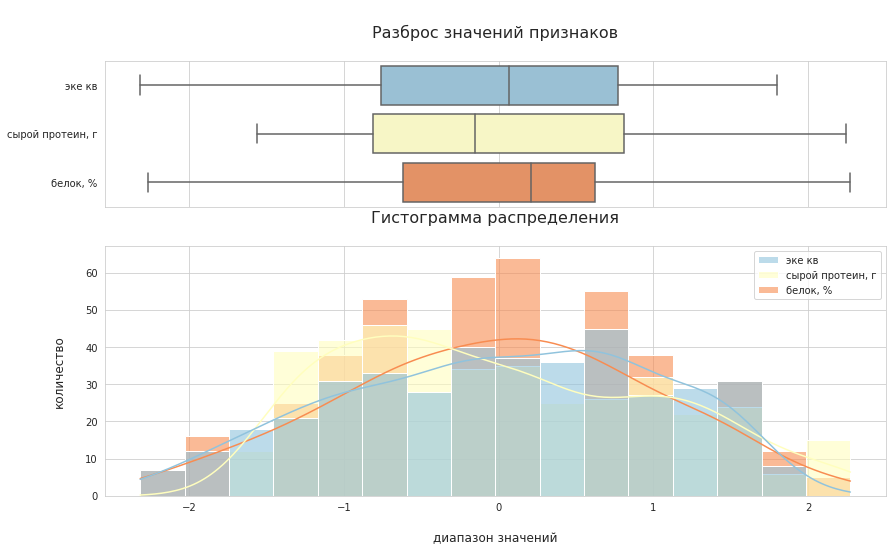

R2 train = 0.878

Веса модели:
x0_холмистое        : +85.690469
x1_менее 2 лет      : -212.633081
x2_меньше 0.915     : -144.558589
x3_меньше 3.675     : -269.547244
x4_буйный           : +337.153955
x4_геркулес         : +340.599158
x4_соловчик         : +24.253176
эке кв              : +123.797295
сырой протеин, г    : +46.826464
белок, %            : -20.295092

Качество модели:
R2 = 0.8183
MAE = 133.35
MSE = 31925.78
RMSE = 178.68



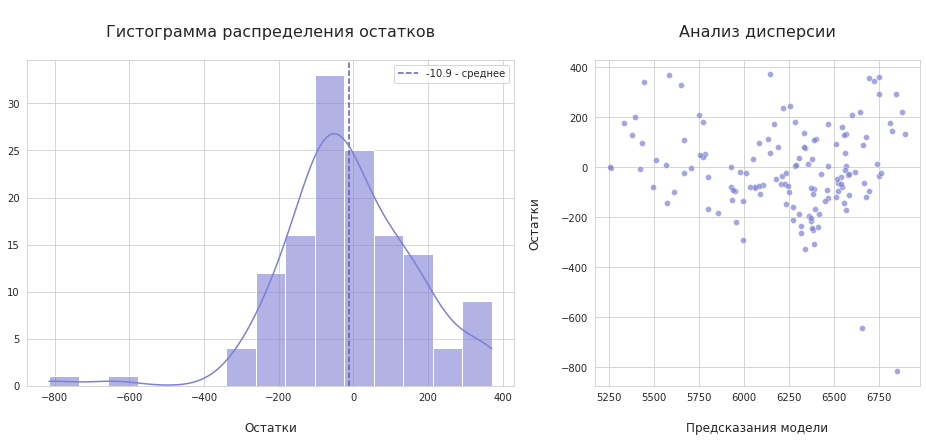

In [52]:
# новый список категориальных и количественных признаков
cat_col_names = ['тип пастбища', 'возраст', 'спо кат', 'жирность кат', 'имя папы']
num_col_names = ['эке кв', 'сырой протеин, г', 'белок, %']

# третья модель линейной регрессии
model_lr3, scaler3, encoder3, fig3, fig_r3 = LR(num_col_names, cat_col_names)

**Влияние** признаков на прогнозы модели изменилось: **для `возраста` и `спо`** оно **уменьшилось**, а для остальных признаков оно увеличилось. **Наиболее значительное** влияние на предсказания теперь оказывают признаки **`имя папы` и `жирность, %`**, в то время как влияние признака `белок, %` минимально.

Третья модель продемонстрировала наилучшую точность: **82% предсказаний** модели ближе к реальным значениям, чем среднее значение целевого признака. Среднее абсолютное отклонение **MAE снизилось до 133 кг**, указывая на более точные предсказания. Корень из средней квадратичной ошибки **RMSE** также **уменьшился до 179 кг**.

Хотя модель по-прежнему склонна к завышению предсказаний, разброс ошибок незначительно уменьшился.

### Лучшая модель

По результатам анализа качества моделей можно сделать вывод, что последняя модель дает лучшие прогнозы. Однако в остатках присутствуют выбросы, а по диаграмме рассеяния видно чередование низкой и высокой дисперсии остатков. Так как качество модели зависит от обучающего набора данных, то можно найти лучшую модель, меняя значение `random_state` (возьмем диапазон от 0 до 100 с шагом 1).

In [53]:
# поиск оптимального RANDOM_STATE
def RS(num_col_names, cat_col_names, target='удой, кг', RANDOM_STATE=42):
    
    # подготовка данных 
    (scaler, encoder,
     X_train, X_test, y_train, y_test) = prepare_data(num_col_names, cat_col_names, target, RANDOM_STATE, srch=True)
    
    # модель LR
    model_lr, predictions = fit_lr(X_train, y_train, X_test, y_test, srch=True)
    
    # метрики
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions)**0.5
    mean = (y_test-predictions).mean()
    
    return [predictions, r2, mae, rmse, mean]

l = []
pred = {}
for i in range(0, 101):
    row = RS(num_col_names, cat_col_names, RANDOM_STATE=i)
    row.append(i)
    
    # запоминаем значения, которые лучше текущей модели
    if (row[1] > 0.85) and (np.abs(row[4]) < 5) and (row[2] < 130) and (row[3] < 160):
        l.append(row[1:])
        pred[i] = row[0]

df = pd.DataFrame(l, columns=['r2', 'mae', 'rmse', 'mean', 'rs'])

# всего найдено
print(df.shape)

# получим 20 лучших значений по r2, затем 10 лучших по rmse, из них выведем пять лучших по mae
df.sort_values(by='r2').tail(20).sort_values(by='rmse').head(10).sort_values(by='mae').head()

(9, 5)


,r2,mae,rmse,mean,rs
7,0.888196,117.972640,145.097400,-2.693890,74
5,0.879791,119.468846,155.568842,-4.838892,37
4,0.869267,123.806017,157.943222,2.314143,35
3,0.872463,126.227704,159.026701,1.640026,22
2,0.897392,126.702189,156.804862,-4.816729,17


В заданном диапазоне удалось найти девять удовлетворяющих требованиям значений `RANDOM_STATE`, лучшее из них равно 74. Точность модели значительно возросла: **R2 = 89%, MAE = 118, RMSE = 145**.

Сохраним данную модель и посмотрим на распределение остатков.

,x0_холмистое,x1_менее 2 лет,x2_меньше 0.915,x3_меньше 3.675,x4_буйный,x4_геркулес,x4_соловчик,эке кв,"сырой протеин, г","белок, %"
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.594790,0.270630,0.487970
1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,-0.594790,0.829585,-0.303386
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.331003,-0.062484,-0.303386
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.684890,1.693425,-0.303386
4,1.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.376099,-1.496571,-1.490420


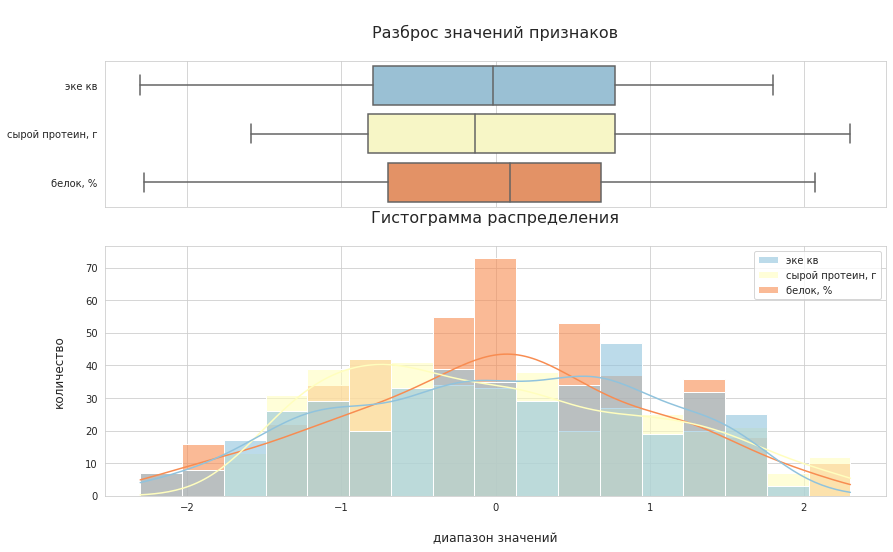

R2 train = 0.856

Веса модели:
x0_холмистое        : +69.137913
x1_менее 2 лет      : -211.313237
x2_меньше 0.915     : -153.636751
x3_меньше 3.675     : -275.445570
x4_буйный           : +341.032172
x4_геркулес         : +323.166450
x4_соловчик         : +23.710174
эке кв              : +109.836843
сырой протеин, г    : +43.765406
белок, %            : -21.727113

Качество модели:
R2 = 0.8882
MAE = 117.97
MSE = 21053.26
RMSE = 145.10



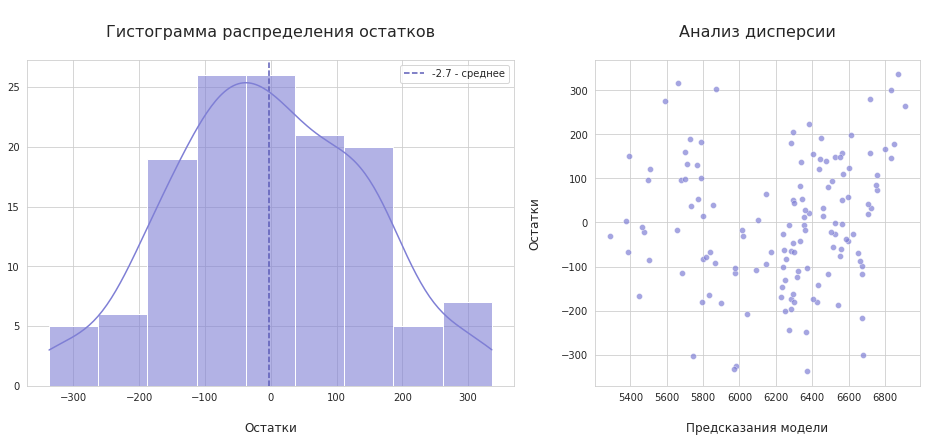

In [54]:
model_lr, scaler_lr, encoder_lr, fig_lr, fig_r_lr = LR(num_col_names, cat_col_names, RANDOM_STATE=74)

Уменьшилось смещение распределения, диапазон значений остатков сократился - 95% остатков лежит в интервале от -303 до 294, выбросы отсутствуют, дисперсия стала более стабильной. Для прогнозирования удоя коров будет использована данная модель.

Найдем доверительный интервал.

In [55]:
print('95% доверительный интервал =', st.norm.interval(confidence=0.95, loc=np.mean(pred[74]), scale=st.sem(pred[74])))

95% доверительный интервал = (6166.820669655116, 6300.107851842301)


С вероятностью 95% истинное среднее значение будет находиться в диапазоне от 6166.82 до 6300.11 кг.

### Прогнозирование удоя

Применим нашу модель к предоставленным «ЭкоФермой» данным, но сначала необходимо добавить недостающие столбцы.

In [56]:
# список признаков
cat_col_names = ['тип пастбища', 'возраст', 'спо кат', 'жирность кат', 'имя папы']
num_col_names = ['эке кв', 'сырой протеин, г', 'белок, %']

# добавление столбцов
buy['спо'] = main['спо'].mean()*1.05
buy['эке'] = main['эке'].mean()*1.05
buy['сырой протеин, г'] = main['сырой протеин, г'].mean()*1.05

# преобразование столбцов
buy['спо кат'] = buy['спо'].apply(lambda x: to_cat(x, 0.915))
buy['жирность кат'] = buy['жирность, %'].apply(lambda x: to_cat(x, 3.675))
buy['эке кв'] = buy['эке']**2

# проверка
buy.head()

,порода,тип пастбища,порода папы быка,имя папы,"жирность, %","белок, %",возраст,спо,эке,"сырой протеин, г",спо кат,жирность кат,эке кв
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164
2,рефлешн соверинг,равнинное,соверин,барин,3.59,3.074,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164
3,рефлешн соверинг,холмистое,айдиал,буйный,3.40,3.061,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164
4,рефлешн соверинг,равнинное,айдиал,буйный,3.64,3.074,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164


Получим предсказания модели.

In [57]:
# масштабирование
X_scaled = scaler_lr.transform(buy[num_col_names])
X_ohe = encoder_lr.transform(buy[cat_col_names])

encoder_col_names = encoder_lr.get_feature_names()

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)

# предсказание
buy['удой, кг'] = model_lr.predict(X)

# посмотрим, сколько коров дают более 6000 кг молока
print(f"Всего: {buy['удой, кг'].count()}")
print(f"Подходит: {buy.loc[buy['удой, кг']>=6000, 'удой, кг'].count()}")

buy.head()

Всего: 20
Подходит: 19


,порода,тип пастбища,порода папы быка,имя папы,"жирность, %","белок, %",возраст,спо,эке,"сырой протеин, г",спо кат,жирность кат,эке кв,"удой, кг"
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6411.006656
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6105.436519
2,рефлешн соверинг,равнинное,соверин,барин,3.59,3.074,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6035.896176
3,рефлешн соверинг,холмистое,айдиал,буйный,3.40,3.061,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6557.826506
4,рефлешн соверинг,равнинное,айдиал,буйный,3.64,3.074,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6376.928348


После вычисления удоя коров с использованием модели, 19 коров из 20 удовлетворяют требованиям фермера.

### Вывод

Были разработаны три модели линейной регрессии, и для наилучшей из них был выбран оптимальный набор данных для обучения, который показал лучшие результаты. С использованием этой модели был сделан прогноз удоя коров на «ЭкоФерме».

**Особенности модели:**
Значительное влияние на предсказания оказывают признаки `имя папы` и `жирность, %`, в то время как влияние признака `белок, %` минимально.

**Качество модели:**
- R2 = 0.8882
- MAE = 117.97
- MSE = 21053.26
- RMSE = 145.10

**Остатки:**
- распределение близко к нормальному
- смещение миниимально
- дисперсия не совсем стабильна
- доверительный интервал: от -302.79 до 293.59

**Результат:** 19 из 20 коров соответствуют требованиям.

<a id='step6'></a>
## Обучение модели логистической регрессии

Для создания и анализа модели логстической регрессии добавим необходимые функции.

In [58]:
# создание модели логистической регрессии
def fit_logr(X_train, y_train, X_test, y_test):
    # создаём объект для работы с моделью
    clf = LogisticRegression()

    # настраиваем модель на данные
    clf = clf.fit(X_train, y_train)

    # получаем прогнозные значения
    y_pred = clf.predict(X_test) 
    y_pred_proba = clf.predict_proba(X_test)

    print('\n\033[1mВеса модели:\033[0m')
    
    for feature_number, feature_name in enumerate(X_train.columns):
        weight = clf.coef_[0, feature_number]
        print(f'{feature_name:<20}: {weight:+.6f}') 
    
    return clf, y_pred, y_pred_proba
    
    
# метрики
def metrics(y_test, y_pred):
    
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    print('\n\033[1mОценка качества модели:\033[0m')
    print(f'accuracy:  {acc:.6f}')
    print(f'recall:    {recall:.6f}')
    print(f'precision: {precision:.6f}')
    
    # матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # график
    sns.heatmap(cm, annot=True, fmt='d', center=0, cmap= 'RdYlBu', ax=ax)
    
    # подписи
    chart_labels(title='Матрица ошибок', 
                 xlabel='Предсказанные значения', ylabel='Истинные значения', ax=ax)
    
    plt.show()
    
    
# модель логистической регрессии
def LogR(num_col_names, cat_col_names, target='вкус'):
    
    # подготовка данных 
    scaler, encoder, X_train, X_test, y_train, y_test = prepare_data(num_col_names, cat_col_names, target, RANDOM_STATE=42, srch=False)
    
    # модель LogR
    clf, predictions, y_pred_proba = fit_logr(X_train, y_train, X_test, y_test)
    
    # метрики
    fig_m = metrics(y_test, predictions)
    
    return clf, X_test, y_test, scaler, encoder, fig#, fig_r


Так как ранее было обнаружено, что признак `спо` на определенных интервалах принимает разные значения, преобразуем его в категориальный, используя более четкое разделение.

In [59]:
def to_cat1(x):
    
    if x < 0.89:
        return 'мене 0.89'
    elif x < 0.93:
        return 'мене 0.93'
    elif x > 0.93:
        return 'более 0.93'
    else:
        return 'равно 0.93'
    
main['спо кат2'] = main['спо'].apply(to_cat1)

### Создание модели

Для обучения данной модели были отобраны следующие признаки: `тип пастбища`, `спо`, `жирность`, `эке`, `сырой протеин, г`, `белок, %`. Возьмем категориальное значение жирности, а также эке в квадрате.

Перед обучением модели присвоим метку класса **1** значению целевого признака **вкусно**, **0 - не вкусно**.

,x0_холмистое,x1_мене 0.89,x1_мене 0.93,x1_равно 0.93,x2_меньше 3.675,эке кв,"сырой протеин, г","белок, %"
0,1.0,0.0,0.0,0.0,0.0,1.321902,2.206848,1.860253
1,1.0,0.0,0.0,0.0,0.0,0.769271,0.343083,0.208971
2,0.0,0.0,0.0,1.0,0.0,0.324575,-0.705285,-1.442311
3,0.0,0.0,1.0,0.0,1.0,-0.764282,0.293161,0.208971
4,0.0,0.0,0.0,1.0,0.0,0.324575,-0.666456,-0.616670



Веса модели:
x0_холмистое        : +0.919358
x1_мене 0.89        : -0.843698
x1_мене 0.93        : +0.663955
x1_равно 0.93       : -2.269055
x2_меньше 3.675     : -0.198552
эке кв              : +0.443351
сырой протеин, г    : +0.114920
белок, %            : +0.099482

Оценка качества модели:
accuracy:  0.622222
recall:    0.684211
precision: 0.658228


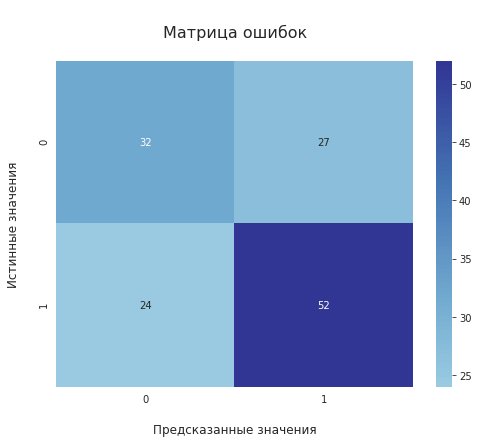

In [60]:
# преобразование целевого признака
main['вкус'] = main['вкус молока'].apply(lambda x: 1 if x=='вкусно' else 0)

# список отобранных признаков
cat_col_names = ['тип пастбища', 'спо кат2', 'жирность кат']
num_col_names = ['эке кв', 'сырой протеин, г', 'белок, %']

# обучение модели
clf, X_test, y_test, scaler, encoder, fig = LogR(num_col_names, cat_col_names)

Наиболее значимые признаки для модели: `тип пастбища` и `спо`, наимене значимый - `белок, %`.
Модель 27 раз ошибочно предсказывает, что молоко вкусное, и 24 раза — что невкусное.

Качество модели по предсказанию вкуса молока - около 62%.

Модель классификации может присвоить класс 1 всем объектам этого класса с эффективностью 68%.

Точность, с которой модель присваивает объектам класс 1 равна 66%, так как фермеру важно знать, будет ли корова давать вкусное молоко, нельзя допускать ошибок первого рода, необходимо ее минимизировать. Для этого найдем порог, при котором модель не будет допускать ошибок первого рода.


### Задача минимизации ошибки первого рода

Создадим функцию, которая будет увелчивать порог до тех пор, пока значение precision будет менее 100%.

Порог = 0.8700000000000003

Оценка качества модели:
accuracy:  0.600000
recall:    0.289474
precision: 1.000000


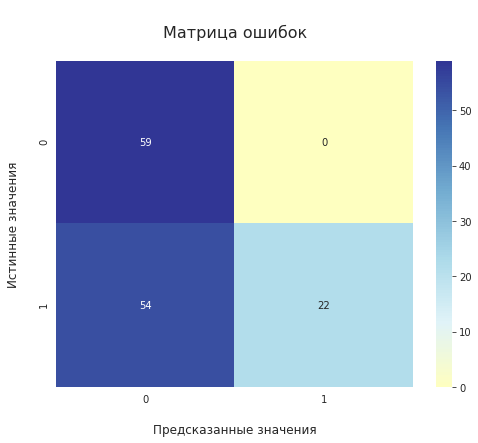

In [61]:
def coef(clf, X_test, y_test):
    
    # предсказанные метки классов
    y_pred = clf.predict(X_test) 
    # вероятность принадлежности к классу 1
    y_pred_proba = clf.predict_proba(X_test)

    # начальный порог
    threshold = 0.5
    
    while precision_score(y_test, y_pred) < 1:
        
        threshold += 0.01
        
        # новые метки классов
        for i in range(len(y_pred)):
            y_pred[i] = 1 if y_pred_proba[i, 1] >= threshold else 0
            
    return threshold, y_pred

# нахождение порога
threshold, y_pred = coef(clf, X_test, y_test)

print(f'Порог = {threshold}')

# оценка качества с новым порогом
metrics(y_test, y_pred)

Значение precision стало равно 100% - классу 0 не присваевается класс 1.

### Прогнозирование вкуса молока

Теперь модель ошибочно не считает молоко вкусным. Применим получившуюся модель к таблице `buy`.

In [62]:
# преобразованиие признака
buy['спо кат2'] = buy['спо'].apply(to_cat1)

# масштабирование
X_scaled = scaler.transform(buy[num_col_names])
X_ohe = encoder.transform(buy[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)

# предсказание
buy['вероятность'] = clf.predict_proba(X)[:, 1]
buy['вкус'] = buy['вероятность'].apply(lambda x: 1 if x >= threshold else 0)

# количество вкусного молока
print(f"Вкусное молоко: {buy.loc[buy['вкус']==1, 'вкус'].count()}")

buy.head()

Вкусное молоко: 1


,порода,тип пастбища,порода папы быка,имя папы,"жирность, %","белок, %",возраст,спо,эке,"сырой протеин, г",спо кат,жирность кат,эке кв,"удой, кг",спо кат2,вероятность,вкус
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6411.006656,более 0.93,0.853991,0
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6105.436519,более 0.93,0.741204,0
2,рефлешн соверинг,равнинное,соверин,барин,3.59,3.074,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6035.896176,более 0.93,0.682386,0
3,рефлешн соверинг,холмистое,айдиал,буйный,3.40,3.061,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6557.826506,более 0.93,0.759552,0
4,рефлешн соверинг,равнинное,айдиал,буйный,3.64,3.074,более 2 лет,0.964595,15.52302,2040.475929,больше 0.915,меньше 3.675,240.964164,6376.928348,более 0.93,0.682386,0


По предсказаниям модели только одна корова дает вкусное молоко.

С учетом строгих критериев фермера, «ЭкоФерма» может предложить только одну корову.

### Вывод

Разработана модель логистической регресси, а также минимизирована ошибка первого рода. Были присвоены предсказанные метки класса коровам из «ЭкоФермы».

**Качество модели:**
- accuracy:  0.60
- recall:    0.29
- precision: 1.00

**Порог классификации:** 0.87

**Результат:** 1 из 20 коров соответствуют требованиям.

<a id='step7'></a>
## Итоговые выводы


### Сводка: данные от «ЭкоФермы» и результаты моделей МО

В результате работы моделей линейной и логистической регресси были получены прогнозные значения удоя и вкуса молока. 
Для удобства восприятия, эти прогнозы будут внесены в исходную таблицу с данными о коровах, рассматриваемых для приобретения.

In [63]:
# исходная таблица с предсказанными значениями
result = buy[['порода', 'тип пастбища', 'порода папы быка', 'имя папы', 'жирность, %', 'белок, %', 'возраст', 'удой, кг']].copy()
result['вкус молока'] = buy['вкус'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
result.head()

,порода,тип пастбища,порода папы быка,имя папы,"жирность, %","белок, %",возраст,"удой, кг",вкус молока
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более 2 лет,6411.006656,не вкусно
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее 2 лет,6105.436519,не вкусно
2,рефлешн соверинг,равнинное,соверин,барин,3.59,3.074,более 2 лет,6035.896176,не вкусно
3,рефлешн соверинг,холмистое,айдиал,буйный,3.40,3.061,более 2 лет,6557.826506,не вкусно
4,рефлешн соверинг,равнинное,айдиал,буйный,3.64,3.074,более 2 лет,6376.928348,не вкусно


В данной таблице хранятся все данные, предоставленные «ЭкоФермой», а также спрогнозированные значения.

### Отбор коров

Посмотрим, сколько и какие коровы, удовлетворябт требованиям по удою и вкусу молока: удой не менее 6000 килограммов в год и вкусное молоко.

In [64]:
print(f"Количество коров, соответствующиих требованиям - {result.loc[(result['удой, кг'] >= 6000)&(result['вкус молока'] == 'вкусно'), 'удой, кг'].count()}")

result[(result['удой, кг'] >= 6000)&(result['вкус молока'] == 'вкусно')]

Количество коров, соответствующиих требованиям - 1


,порода,тип пастбища,порода папы быка,имя папы,"жирность, %","белок, %",возраст,"удой, кг",вкус молока
16,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.079,более 2 лет,6361.205124,вкусно


С учетом строгих требований к качеству, фермер может приобрести только одну корову. 

Модель линейной регрессии на основе отобранных признаков, коррелирующих с удоем, спрогнозировала  удой коров в год (точность модели 89%). Было выявлено, что удой у 19 коров «ЭкоФермы» составляет не менее 6000 кг.
Однако вторая модель была обучена с учетом исключения ложноположительных результатов, что привело к тому, что только у одной коровы можно было уверенно отнести молоко ко вкусному. 

Именно поэтому минимальные риски будут при покупке только одной коровы.

**Примечание**

Также при наличии данных можно проанализировать, как меняются удой и вкус молока у коров с возрастом. Так как данные показатели у молодых коров хуже, нельзя утверждать, что по мере взросления они не будут меняться. 

### Качество модели

Для улучшения качества модели использовались методы преобразования признаков в категориальные, увеличения линейной зависимости путем возведения признаков в квадрат, добавления новых признаков и изменения набора обучающих данных.

Для дальнейшего улучшения модели линейной регрессии рекомендуется увеличить обучающий набор данных, добавить новые признаки и провести дополнительный отбор признаков для повышения точности предсказаний модели.

### Метрики 

Важными метриками для анализа рисков и экономических расчетов являются:
- Accuracy - показывает долю верных предсказаний от общего количества
- Precision - показывает точность, с которой модель присваивает объектам класс 1
- Recall - измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса

Рекомендуется оценивать эти метрики, чтобы полноценно анализировать риски и принимать обоснованные экономические решения.